<h1>Treci domaci zadatak iz Genomske Informatike</h1>

<h3>Žarko Babić 2023/3109</h3>



 <br />

<h1>Tema: Single cell analysis exercice</h1>

<br />

<h1> Instaliranje i uvozenje potrebnih biblioteka, otvaranje fajla GTEX-1HSMQ-5005 koji sadrzi podatke o celijama plucnog tkiva: </h1>

In [1]:
!pip install anndata
!pip install scanpy
!pip install decoupler
!pip install leidenalg
!pip install omnipath

In [2]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import decoupler as dc
import copy
from sklearn.metrics import davies_bouldin_score

In [3]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1MZ6HmqiCeN5mJd2cYM498PgnNOV8goQ9'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('GTEX-1HSMQ-5005.h5ad')

In [4]:
!wget -O GTEX-1HSMQ-5005.h5ad  "https://drive.usercontent.google.com/download?id=1MZ6HmqiCeN5mJd2cYM498PgnNOV8goQ9&export=download&authuser=0&confirm=t&uuid=b3f632b6-8dd3-4cbe-aade-886aad76299c&at=APZUnTV6ape4OEBvDGLvCmNBfgp0%3A1714034617680"

--2024-05-08 14:22:53--  https://drive.usercontent.google.com/download?id=1MZ6HmqiCeN5mJd2cYM498PgnNOV8goQ9&export=download&authuser=0&confirm=t&uuid=b3f632b6-8dd3-4cbe-aade-886aad76299c&at=APZUnTV6ape4OEBvDGLvCmNBfgp0%3A1714034617680
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.214.132, 2607:f8b0:4001:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.214.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444294630 (424M) [application/octet-stream]
Saving to: ‘GTEX-1HSMQ-5005.h5ad’

GTEX-1HSMQ-5005.h5a 100%[===================>] 423.71M   134MB/s    in 3.2s    

2024-05-08 14:22:56 (134 MB/s) - ‘GTEX-1HSMQ-5005.h5ad’ saved [444294630/444294630]



In [5]:
adata = ad.read_h5ad('GTEX-1HSMQ-5005.h5ad')
adata

AnnData object with n_obs × n_vars = 14404 × 17695
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_length', 'Approved symbol', 'A

<h1> Preprocessing data </h1>

<br/>

<h2>Filtering data (Filtriranje podataka):</h2>

<h3>Most expressed genes in the dataset:</h3>

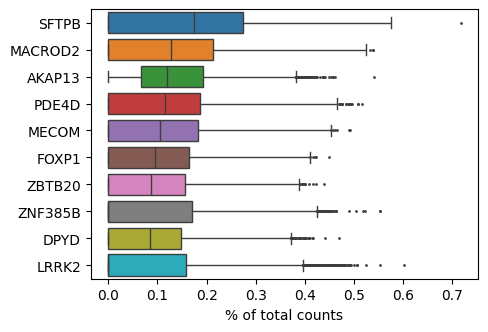

In [6]:
sc.pl.highest_expr_genes(adata, n_top=10)

<h3>Filtriramo celije koje imaju mali broj expresovanih gena, sto nam smanjuje sum. Takodje fitriramo gene koji su prisutni u jako malom broju celija, jer su to geni specificni za te celije, sto nam omogucava smanjenje suma i bias-a. </h3>

In [7]:
sc.pp.filter_cells(adata, min_genes=200)

In [8]:
sc.pp.filter_genes(adata, min_cells=3)

<br/>

<h2>Calculate metrics (Racunanje metrika):</h2>

<h3>Izbacivanje celija iz analize ukoliko sadrze preveliki odnos ekspresovanih gena iz mitohondrija naspram ukupnog broja ekspresovanih gena, jer umanjuju uspesnost dalje analize: </h3>

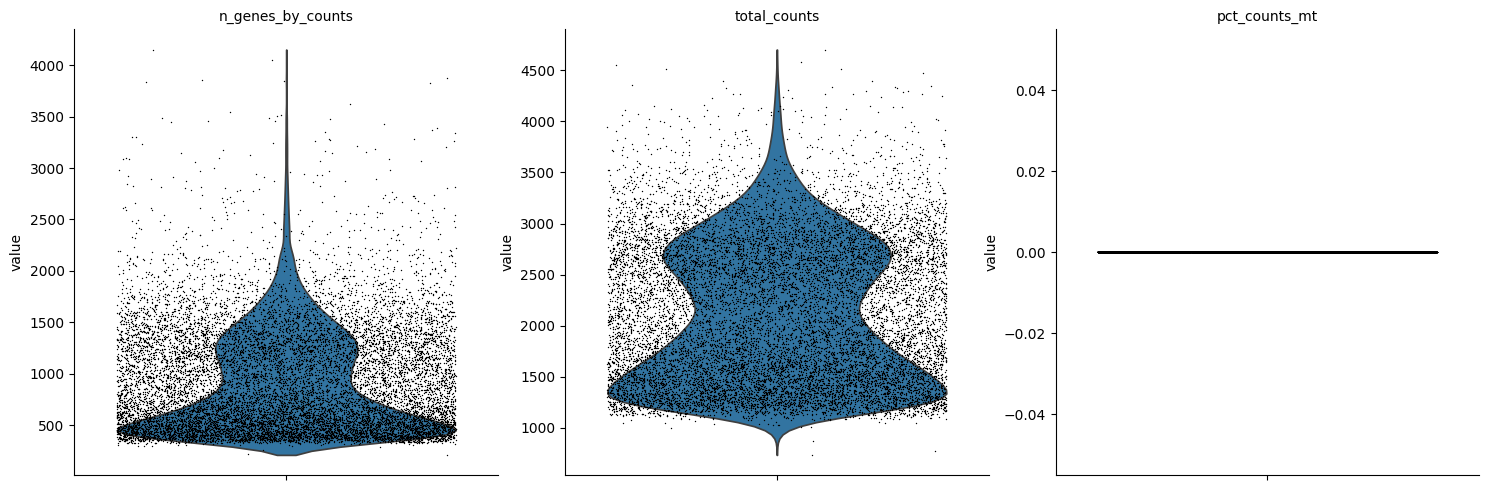

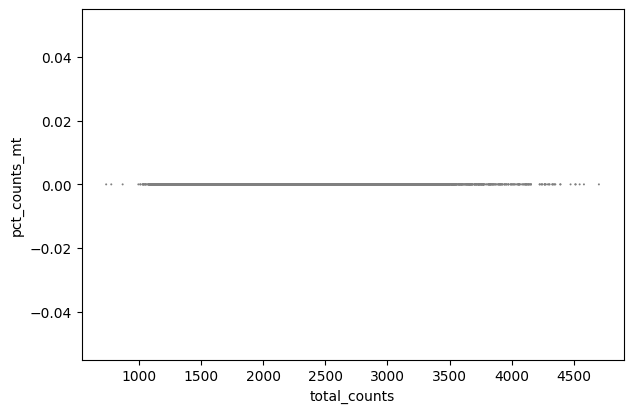

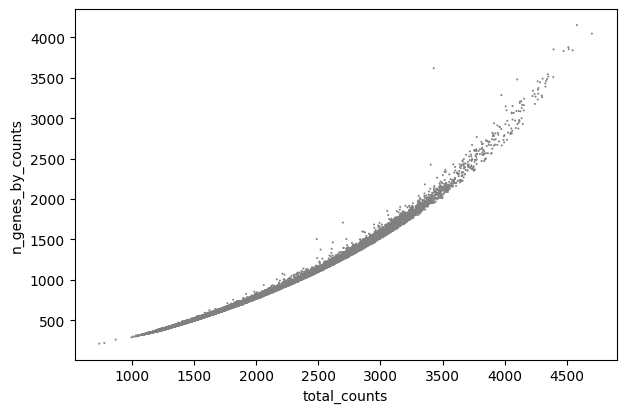

In [9]:
# Markiranje gena iz mitohondrija
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Racunanje metrike i procenta mitohondrijalnih gena
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False,
inplace=True)

# Graficki prikaz
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

Vidimo sa grafika da je kod gotovo svih celija u datasetu mali procenat mitohondrijalnih gena, pa nema potrebe da fitriramo dataset prema ovom kriterijumu.

<h3>Izbacivanje "outlinera" (vrednosti koje odskacu previse od standardne vrednosti), u ovom slucaju celije koje koje imaju preveliki broj ekspresovanih gena, jer to moze potencijalno ukazivati na cinjenicu da su se u jednom gel beadu nasle dve celije zajedno(doublets) ili neki od drugih tehnickih gresaka:  </h3>

In [10]:
adata = adata[adata.obs.n_genes_by_counts < 3500, :]

<br/>

<h2>Normalizacija i log transformacija</h2>

In [11]:
# Normalizacija

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


<br/>

<h2>Geni koji pokazuju znacajnu varijaciju u nivoima izrazavanja sirom celija (Highly variable genes HVGs)</h2>

Geni koji pokazuju znacajnu varijaciju u nivoima izrazavanja sirom celija su geni ciji se nivoi izrazavanja jako razlikuju od celije do celije unutar populacije. Identifikacija gena sa znacajnom varijacijom izražavanja sirom celija je vazna u analizi single cell podataka jer ovi geni cesto igraju kljucne regulatorne uloge u definisanju identiteta i funkcije celija. Fokusiranje na ovakve gene vazna je za dalju analizu jer potpomazu procesu dimensionality reduction, klasterizacije, vizualizacije i downstram analize

In [12]:
# Identifikacija HVG gena
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

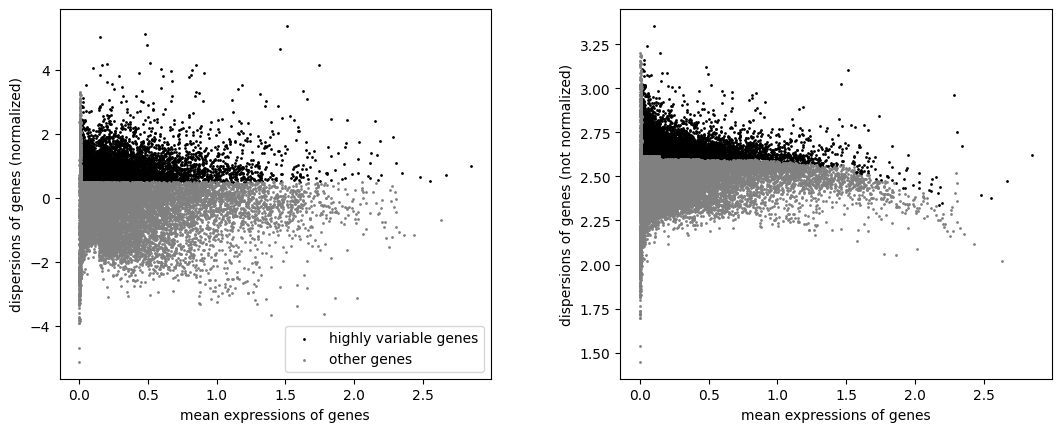

In [13]:
# Vizuelizacija HVG disperzije
sc.pl.highly_variable_genes(adata)

<br/>

<h2>Scaling
(Skaliranje)</h2>

In [14]:
sc.pp.scale(adata, max_value=10)

<br/>

<h2>PCA</h2>

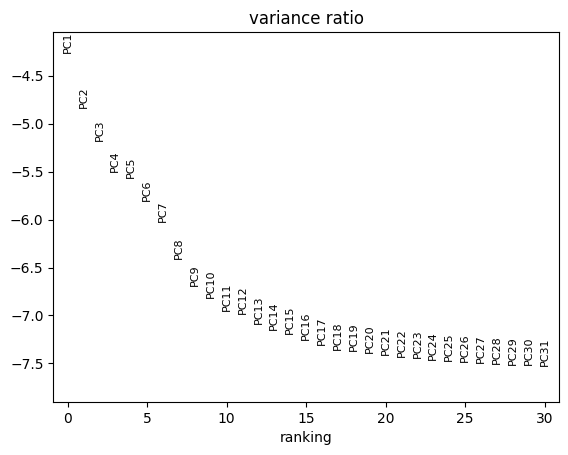

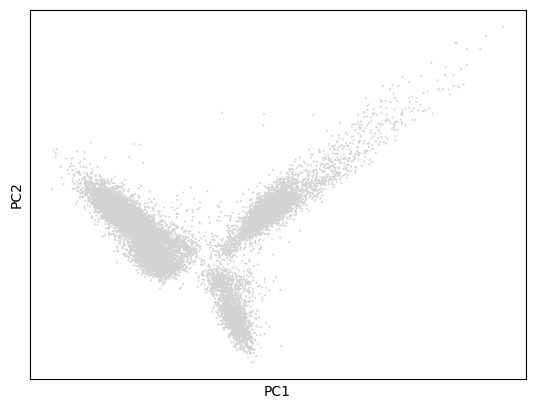

In [15]:
# Scree plot nam pokazuje koliko bismo mogli da uzmemo PC(glavnih komponenta)
# prilikom redukcije, svaka sledeca komponenta pocev od prve manje utice na
# ukupnu varijansu, ipak cemo ostaviti podrazumevanih 50, iako u ovom slucaju
# vidimo da se vrednosti skupljaju oko horizontalne asimptote vec oko 31.
# komponente

#PCA linearna redukcija dimenzija
sc.tl.pca(adata, svd_solver="arpack")

sc.pl.pca_variance_ratio(adata, log=True)



#Vizualizacija
sc.pl.pca(adata)

<br/>

<h2> Kreiranje grafa susedstva (Neighbourhood graph) </h2>

Predstavlja uparene slicnosti ili razdaljine izmedju celija u skupu podataka. Bice koriscen kao osnovna struktura podataka za dalju redukciju dimenzija (UMAP) i klasterizaciju (Leiden)

In [16]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

<br/>

<h2>UMAP redukcija dimenzija</h2>

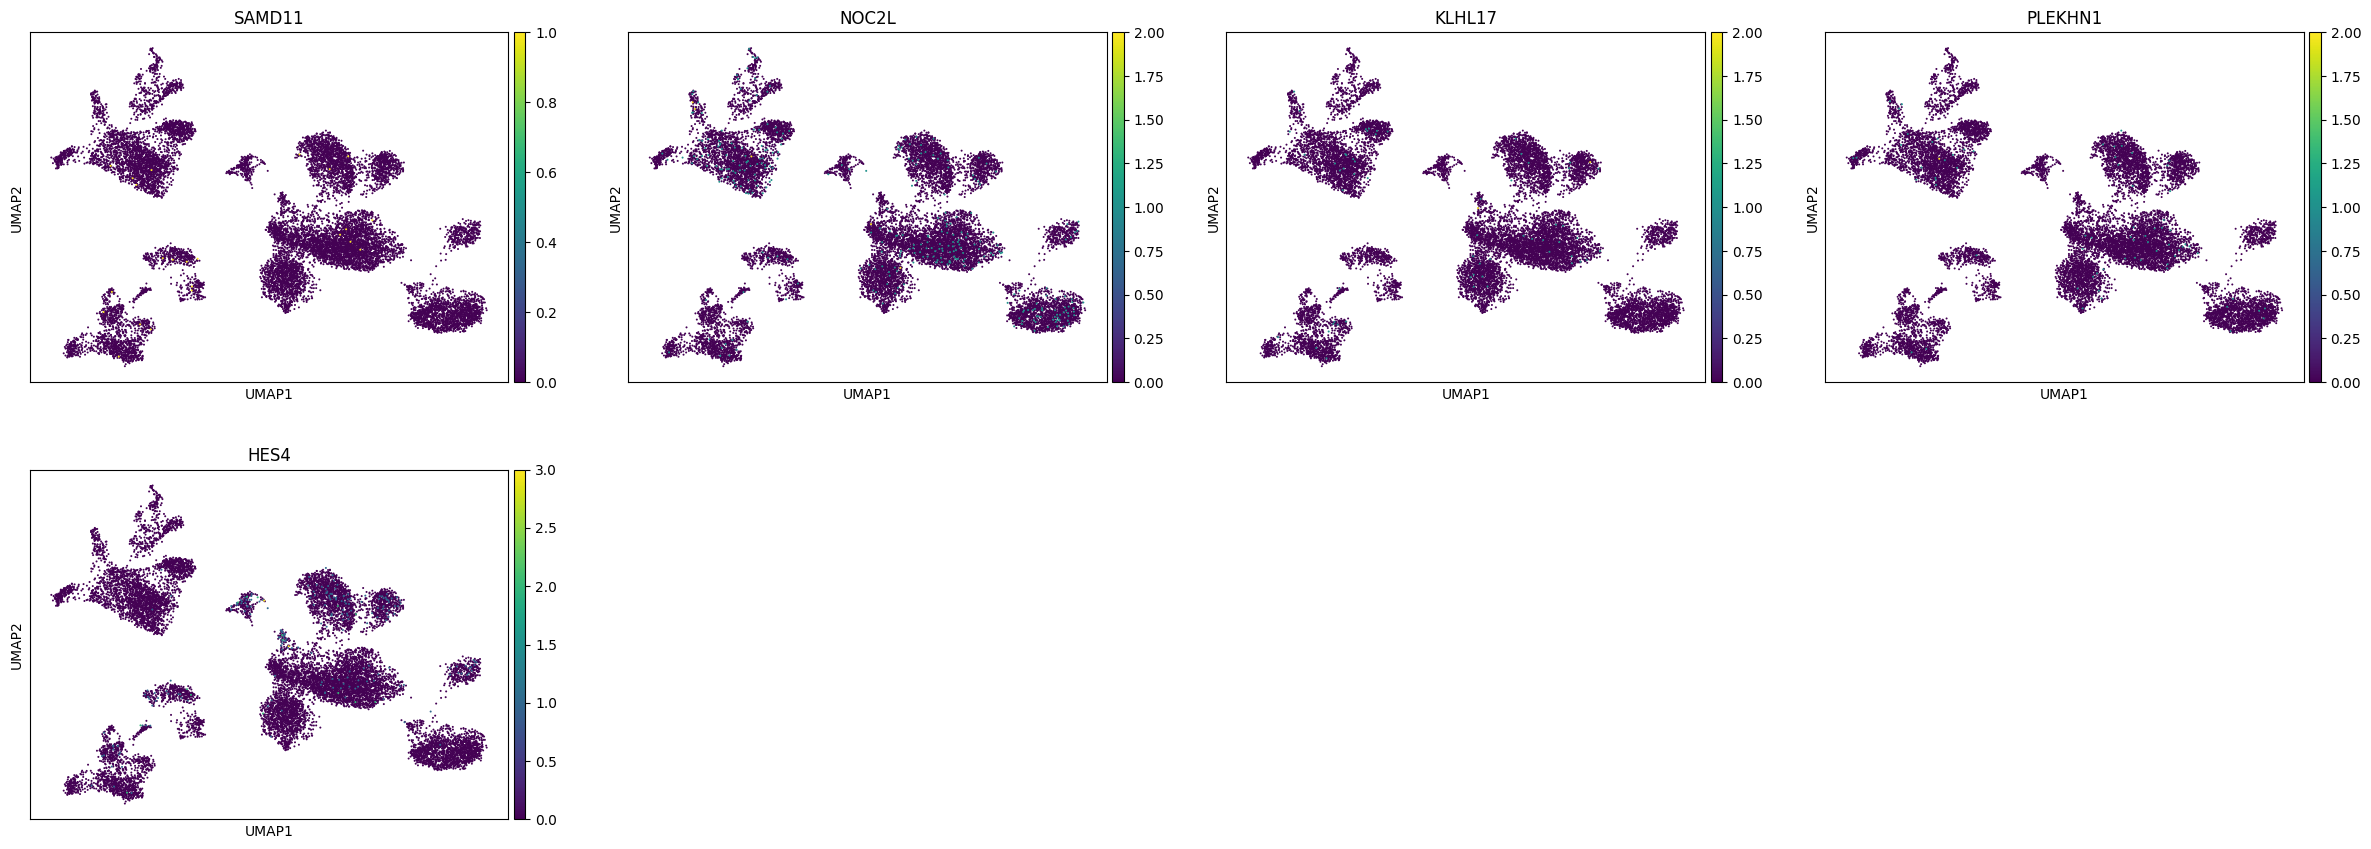

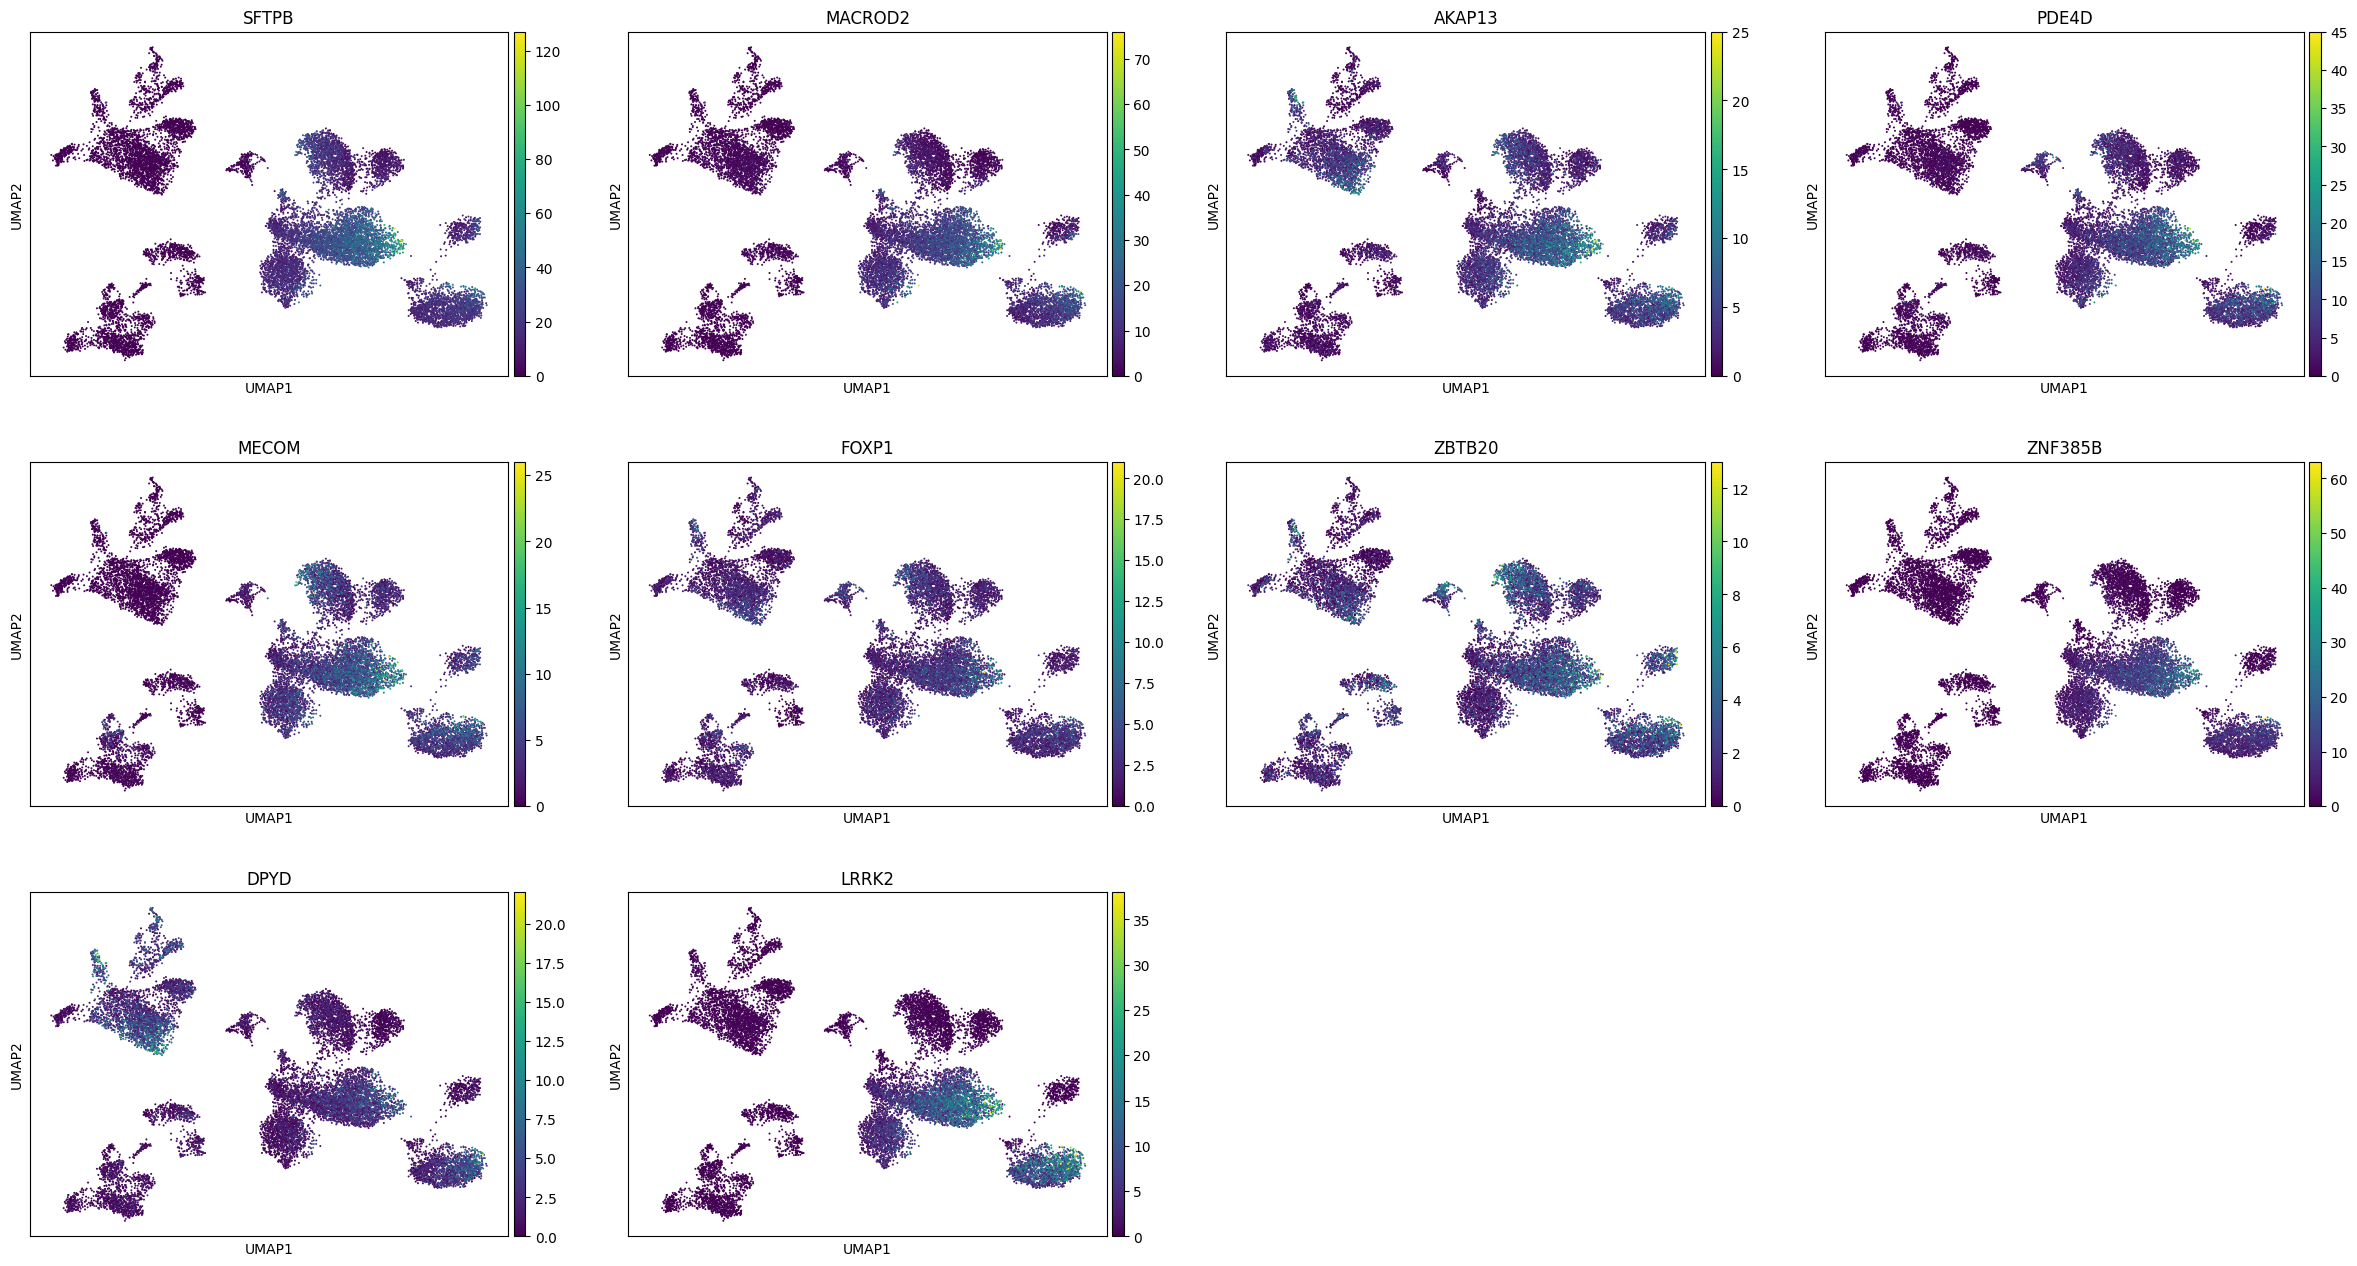

In [17]:
#UMAP redukcija dimenzija
sc.tl.umap(adata)

#Vizuelizacija bojenja 5 HVGova
hvgs = adata.var_names[adata.var['highly_variable']]
hvgs = hvgs[:5]
sc.pl.umap(adata, color=hvgs)

#Vizuelizacija bojenja prethodno izacunatih najekspesovanijih gena
sc.pl.umap(adata, color=["SFTPB", "MACROD2", "AKAP13", "PDE4D", "MECOM", "FOXP1", "ZBTB20", "ZNF385B", "DPYD", "LRRK2"])




<br/>

<br/>

<h2>KLASTERIZACIJA (CLUSTERING)</h2>

<ipython-input-18-63ca1489f87f>:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


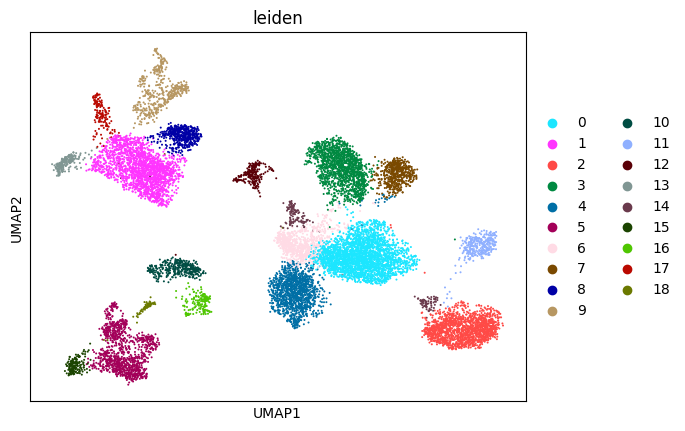

In [18]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color="leiden")

<br/>

<h2>Izracunavanje Davies-Bouldin rezultata za klastere dobijene UMAP-om:</h2>

In [19]:
cluster_labels = adata.obs['leiden']

# Izracunavanje Davies-Bouldin rezultata za klastere
davies_bouldin = davies_bouldin_score(adata.X, cluster_labels)

print("Davies-Bouldin rezultat UMAP klastera sa normalizacijom:")
print(davies_bouldin)

Davies-Bouldin rezultat UMAP klastera sa normalizacijom:
10.789033046437268


<h1>Ponavljanje prostupka radi izracunavanja Davies-Bouldin rezultata za klastere dobijene UMAP-om u slucaju kada podaci prethodno nisu normalizovani

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:664: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


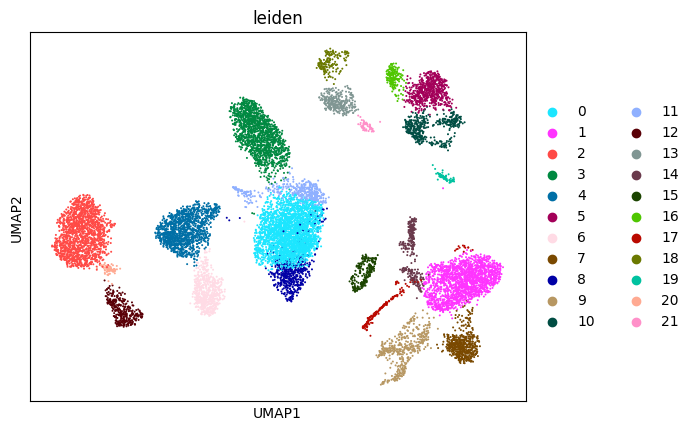

Davies-Bouldin rezultat UMAP klastera bez normalizacije:
11.971881350454781


In [20]:
#Bez normalizacije

adata_without_normalisation = ad.read_h5ad('GTEX-1HSMQ-5005.h5ad')
sc.pp.filter_cells(adata_without_normalisation, min_genes=200)
sc.pp.filter_genes(adata_without_normalisation, min_cells=3)
adata_without_normalisation.var["mt"] = adata_without_normalisation.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata_without_normalisation, qc_vars=["mt"], percent_top=None, log1p=False,
inplace=True)
adata_without_normalisation = adata_without_normalisation[adata_without_normalisation.obs.n_genes_by_counts < 3500, :]

sc.pp.highly_variable_genes(adata_without_normalisation, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata_without_normalisation, max_value=10)
sc.tl.pca(adata_without_normalisation, svd_solver="arpack")
sc.pp.neighbors(adata_without_normalisation, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_without_normalisation)
sc.tl.leiden(adata_without_normalisation)
sc.pl.umap(adata_without_normalisation, color="leiden")

cluster_labels = adata_without_normalisation.obs['leiden']

# Izracunavanje Davies-Bouldin rezultata za klastere
davies_bouldin = davies_bouldin_score(adata_without_normalisation.X, cluster_labels)

print("Davies-Bouldin rezultat UMAP klastera bez normalizacije:")
print(davies_bouldin)


<h1>Zakljucak:</h1>

Davies-Bouldin ocena je metrika koja se koristi za evaluaciju algoritama klasterovanja, i kod nje niza ocena ukazuje na bolji stepen klasterovanja.

Bez normalizacije vrednosti ekspresovanih gena mogu jako puno varirati izmedju celija, sto dovodi do manje koherentnih klastera i vece Davies-Bouldin ocene.

Sa normalizacijom varijacija izmedju vrednosti ekspresovanih gena se smanjuje, podaci pocinju da imaju sve manju medjusobnu razliku, prilagodjavaju se i postaju slicniji, jer se posmatraju na istoj skali, sto potpomaze klasterizaciji, i dovodi do koherentnijih klastera i nize Davies-Bouldin ocene, ukazujuci na bolji stepen klasterizacije.

Takodje, moze se primetiti da postoji vise klastera ukoliko se normalizacija ne vrsi, zbog toga sto zbog velikog variranja podataka i tehnickih faktora koji postoje, moze se desiti da algoritam detektuje suptilnije razlike i deli podatke u vise klastera, iako ti podaci zapravo pripadaju jednom istom klasteru.